# Using Google Earth Engine

## 1. Save gpkg to shp

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

In [ ]:
gpkg_file_path = '../../data/Witzwil.gpkg'
gdf = gpd.read_file(gpkg_file_path)

In [ ]:
# Plot the GeoDataFrame with a background map
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, alpha=0.5, edgecolor='k', cmap='viridis')

cx.add_basemap(ax, crs=gdf.crs.to_string())

plt.show()

## 2. Open saved bare pixels from GEE

In [ ]:
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import geopandas as gpd

In [ ]:
dir_path = '../../data/S2_BS/'
site_names = ['Tan', 'Strickhof', 'SwissFutureFarm', 'Witzwil']
files = [os.path.join(dir_path, f) for f in os.listdir(dir_path)]
farm_bounds = {
  'Tan': '../../data/in_situ_traits_2019/in-situ_glai.shp',
  'Strickhof': '../../data/Strickhof.shp',
  'SwissFutureFarm': '../../data/SwissFutureFarm.shp',
  'Witzwil': '../../data/Witzwil.shp',
}

In [ ]:
for site in site_names:
    site_files = [f for f in files if site in f]

    # Plot each site over multiple years
    num_files = len(site_files)
    max_col = 4
    num_rows = (num_files // max_col) + (1 if num_files % max_col != 0 else 0)

    fig, axs = plt.subplots(num_rows, max_col, figsize=(20, 3 * num_rows))
    fig.suptitle(f'Baresoil {site}', fontsize=16)

    for i, tif_file_path in enumerate(site_files):
        with rasterio.open(tif_file_path) as src:
            # Read all bands
            data = src.read()
            # In Google Earth Engine (GEE), the reflectance values in Sentinel-2 images are scaled by a factor of 10,000
            data /= 10000
            # Get RGB bands (Band 3,2,1)
            rgb = data[[2, 1, 0]]
            
            # Get spatial coordinates for each pixel
            transform = src.transform
            height, width = rgb.shape[1], rgb.shape[2]
            x = np.linspace(transform[2], transform[2] + width * transform[0], width)
            y = np.linspace(transform[5], transform[5] + height * transform[4], height)

            # Set nan values to white
            rgb[np.isnan(rgb)] = 1

            # Plot the RGB image using matplotlib with spatial coordinates
            row_index = i // max_col
            col_index = i % max_col
            ax = axs[row_index, col_index]

            # Plot farm bounds for the first subplot
            if i == 0:
                shapefile_path = farm_bounds[site]
                gdf = gpd.read_file(shapefile_path)
                gdf = gdf.to_crs(epsg=2056)
                ax = gdf.plot(ax=ax, alpha=0.5, edgecolor='black', color='none')
                raster_extent = [x[0], x[-1], y[-1], y[0]]
                ax.set_xlim(raster_extent[0], raster_extent[1])
                ax.set_ylim(raster_extent[2], raster_extent[3])
                ctx.add_basemap(ax, crs=gdf.crs)
            else:
                # Plot RGB image for the remaining subplots
                ax.imshow(rgb.transpose(1, 2, 0), extent=[x[0], x[-1], y[-1], y[0]])
                ax.set_title(tif_file_path.split('/')[-1].split('_')[2])
                ax.set_xlabel('Lon')
                ax.set_ylabel('Lat')

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlap with suptitle
    plt.show()
  

# Find bare soil pixels using EOdal

In [171]:
import geopandas as gpd
import numpy as np
import pandas as pd
import pickle
from typing import List
from shapely.geometry import Polygon, MultiPolygon
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import contextily as cx

import os
from pathlib import Path
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
sys.path.insert(0, os.path.join(base_dir, "eodal"))
import eodal

from datetime import datetime
from eodal.config import get_settings
from eodal.core.scene import SceneCollection
from eodal.core.sensors.sentinel2 import Sentinel2
from eodal.mapper.feature import Feature
from eodal.mapper.filter import Filter
from eodal.mapper.mapper import Mapper, MapperConfigs

Settings = get_settings()
# set to False to use a local data archive
Settings.USE_STAC = True

print(f'EOdal version: {eodal.__version__}')

EOdal version: 0.2.4


## Save data for a list of dates and a shp

In [2]:
shp_path = base_dir.joinpath('data/Strickhof.shp')
dates = ['2017-10-07', '2017-12-26']
res_dir = base_dir.joinpath('results/eodal_s2_baresoil') # where to save rasters

In [3]:
aoi = gpd.read_file(shp_path).dissolve()

In [4]:
def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
    interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True, cloud_classes=[3, 8, 9, 10, 11])
    return ds


    

def extract_s2_data(
        aoi: gpd.GeoDataFrame,
        time_start: datetime,
        time_end: datetime,
        scene_cloud_cover_threshold: float = 80,
        feature_cloud_cover_threshold: float = 50,
        spatial_resolution: int = 10
    ) -> SceneCollection:
    """
    Extracts Sentinel-2 data from the STAC SAT archive for a given area and time period.
    Scenes that are too cloudy or contain nodata (blackfill), only, are discarded.

    The processing level of the Sentinel-2 data is L2A (surface reflectance factors).

    :param parcel:
        field parcel geometry (defines the spatial extent to extract)
    :param time_start:
        start of the time period to extract
    :param end_time:
        end of the time period to extract
    :param scene_cloud_cover_threshold:
        scene-wide cloudy pixel percentage (from Sentinel-2 metadata) to filter out scenes
        with too high cloud coverage values [0-100%]
    :param feature_cloud_cover_threshold:
        cloudy pixel percentage [0-100%] on the parcel level. Only if the parcel has a
        lower percentual share of cloudy pixels (based on the scene classification layer) than
        the threshold specified, the Sentinel-2 observation is kept
    :param spatial_resolution:
        spatial resolution of the Sentinel-2 data in meters (Def: 10m)
    :param resampling_method:
        spatial resampling method for those Sentinel-2 bands not available in the target
        resolution. Nearest Neighbor by default
    :returns:
        dictionary with the list of scenes for the field parcel (`feature_scenes`), the
        DataFrame of (un)used scenes and the reason for not using plus some basic scene
        metadata (`scene_properties`)
    """
    # setup the metadata filters (cloud cover and processing level)
    metadata_filters = [
        Filter('cloudy_pixel_percentage','<', scene_cloud_cover_threshold),
        Filter('processing_level', '==', 'Level-2A')
    ]
    # setup the spatial feature for extracting data
    feature = Feature.from_geoseries(aoi.geometry)
    
    # set up mapping configs
    mapper_configs = MapperConfigs(
        collection='sentinel2-msi',
        time_start=time_start,
        time_end=time_end,
        feature=feature,
        metadata_filters=metadata_filters
    )

    # get a new mapper instance. Set sensor to `sentinel2`
    mapper = Mapper(mapper_configs)

    # query the STAC (looks for available scenes in the selected spatio-temporal range)
    mapper.query_scenes()

    # get observations (loads the actual Sentinel2 scenes)
    # the data is extract for the extent of the parcel
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,            # this tells the mapper how to read and load the data (i.e., Sentinel-2 scenes)
        'scene_constructor_kwargs': {},                      # here you could specify which bands to read
        'scene_modifier': preprocess_sentinel2_scenes,       # this tells the mapper about (optional) pre-processing of the loaded scenes (must be a callable)
        'scene_modifier_kwargs': {'target_resolution': 10}   # here, you have to specify the value of the arguments the `scene_modifier` requires
    }
    mapper.load_scenes(scene_kwargs=scene_kwargs)

    # loop over available Sentinel-2 scenes stored in mapper.data as a EOdal SceneCollection and check
    # for no-data. These scenes will be removed from the SceneCollection
    scenes_to_del = []
    mapper.metadata['scene_used'] = 'yes'

    if mapper.data is not None:
        for scene_id, scene in mapper.data:

            # check if scene is blackfilled (nodata); if yes continue
            if scene.is_blackfilled:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [blackfill]'
                continue

            # check cloud coverage (including shadows and snow) of the field parcel
            feature_cloud_cover = scene.get_cloudy_pixel_percentage(cloud_classes=[3, 8, 9, 10, 11])

            # if the scene is too cloudy, we skip it
            if feature_cloud_cover > feature_cloud_cover_threshold:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [clouds]'
                continue

            # calculate the NDVI and NBR2
            scene.calc_si('NDVI', inplace=True)
            scene.calc_si('NBR2', inplace=True)

        # delete scenes too cloudy or containing only no-data
        for scene_id in scenes_to_del:
            del mapper.data[scene_id]
    
    return mapper


In [16]:
for d in dates:
  start_date = datetime.strptime(d, '%Y-%m-%d')
  end_date = start_date + timedelta(days=1)
  
  # Query for that date
  mapper = extract_s2_data(
    aoi=aoi,
    time_start=start_date,
    time_end=end_date
  )

  if mapper.data is not None:
    # Save raster for that date
    if not os.path.exists(res_dir):
      os.makedirs(res_dir)
      
    for scened_id, scene in mapper.data:
      scene.to_rasterio(f'{res_dir}/{d}.tif')


2024-01-31 17:00:09,857 eodal        INFO     Starting extraction of sentinel2 scenes


None


2024-01-31 17:00:10,695 eodal        INFO     Finished extraction of sentinel2 scenes
/mnt/eo-nas1/eoa-share/projects/010_CropCovEO/eodal/eodal/mapper/mapper.py:887: UserWarning: No scenes were found - consider modifying your search criteria
  warnings.warn(


In [11]:
# Could then open the data and apply thresholds on ndvi and nbr2 and get bare soil

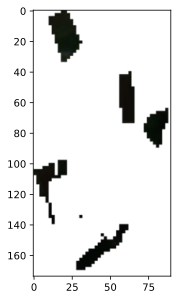

In [43]:
# Check saved data

import rasterio
import matplotlib.pyplot as plt
import numpy as np

with rasterio.open(f'{res_dir}/{d}.tif') as src:
    # Read all bands
    data = src.read()
    rgb = data[[2, 1, 0]]
    rgb[rgb==0] = 1
    plt.imshow(rgb.transpose(1, 2, 0))

## Retrieve dates with baresoil
- add buffer around field/geometry egde
- keep only bare soil pixels

In [173]:
shp_path = base_dir.joinpath('data/Strickhof.shp')
res_dir = base_dir.joinpath('results/eodal_s2_baresoil') # where to save rasters

In [174]:
aoi = gpd.read_file(shp_path).dissolve()
aoi = aoi.to_crs('EPSG:2056')

aoi_with_buffer = aoi.copy()
buffer_distance = -20 # in meters
aoi_with_buffer['geometry'] = aoi.buffer(buffer_distance)
aoi_with_buffer = aoi_with_buffer.to_crs('EPSG:4326')

<Axes: >

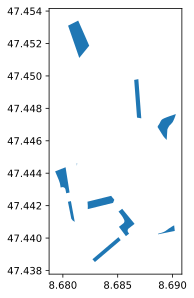

In [175]:
aoi_with_buffer.plot()

In [177]:
# Use GeoWP to get more surrounding fields

geowp_path = '/home/f80873755@agsad.admin.ch/mnt/Data-Work-RE/27_Natural_Resources-RE/99_GIS_User_protected/GeoWP/Landuse/Landw_Kulturflaechen/2021/01_Geodata/SHP/Nutzungsflaechen_BLW_Schweizweit_merge/ln_nutzung_BLW_2021_CH.shp'
geowp = gpd.read_file(geowp_path).to_crs(aoi.crs)

In [178]:
geowp = geowp.cx[aoi.total_bounds[0]:aoi.total_bounds[2], aoi.total_bounds[1]:aoi.total_bounds[3]]
geowp_with_buffer = geowp.copy()
buffer_distance = -60 # in meters, if the crs of the gdf is metric
geowp_with_buffer['geometry'] = geowp.buffer(buffer_distance)

<Axes: >

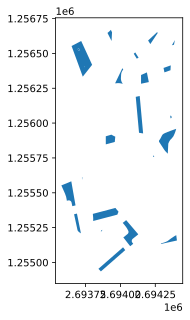

In [181]:
geom = gpd.overlay(aoi_with_buffer.to_crs(geowp_with_buffer.crs), geowp_with_buffer, how='union')
geom.plot()

<Axes: >

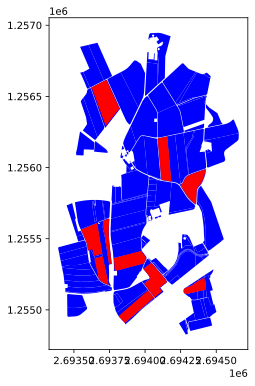

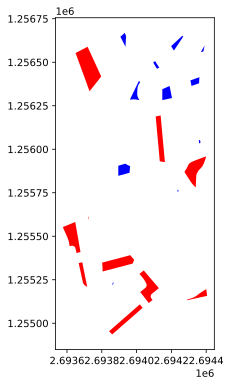

In [180]:
fig, ax = plt.subplots(figsize=(8,6))
geowp.plot(ax=ax, color='b')
aoi.plot(ax=ax, color='r')

fig, ax = plt.subplots(figsize=(8,6))
geowp_with_buffer.plot(ax=ax, color='b')
aoi_with_buffer.to_crs(geowp_with_buffer.crs).plot(ax=ax, color='r')

In [76]:
def preprocess_sentinel2_scenes(
    ds: Sentinel2,
    target_resolution: int,
) -> Sentinel2:
    """
    Resample Sentinel-2 scenes and mask clouds, shadows, and snow
    based on the Scene Classification Layer (SCL).

    NOTE:
        Depending on your needs, the pre-processing function can be
        fully customized using the full power of EOdal and its
    interfacing libraries!

    :param target_resolution:
        spatial target resolution to resample all bands to.
    :returns:
        resampled, cloud-masked Sentinel-2 scene.
    """
    # resample scene
    ds.resample(inplace=True, target_resolution=target_resolution)
    # mask clouds, shadows, and snow
    ds.mask_clouds_and_shadows(inplace=True, cloud_classes=[3, 8, 9, 10, 11])
    return ds


    

def extract_s2_data(
        aoi: gpd.GeoDataFrame,
        time_start: datetime,
        time_end: datetime,
        scene_cloud_cover_threshold: float = 50,
        feature_cloud_cover_threshold: float = 80,
        spatial_resolution: int = 10
    ) -> SceneCollection:
    """
    Extracts Sentinel-2 data from the STAC SAT archive for a given area and time period.
    Scenes that are too cloudy or contain nodata (blackfill), only, are discarded.

    The processing level of the Sentinel-2 data is L2A (surface reflectance factors).

    :param parcel:
        field parcel geometry (defines the spatial extent to extract)
    :param time_start:
        start of the time period to extract
    :param end_time:
        end of the time period to extract
    :param scene_cloud_cover_threshold:
        scene-wide cloudy pixel percentage (from Sentinel-2 metadata) to filter out scenes
        with too high cloud coverage values [0-100%]
    :param feature_cloud_cover_threshold:
        cloudy pixel percentage [0-100%] on the parcel level. Only if the parcel has a
        lower percentual share of cloudy pixels (based on the scene classification layer) than
        the threshold specified, the Sentinel-2 observation is kept
    :param spatial_resolution:
        spatial resolution of the Sentinel-2 data in meters (Def: 10m)
    :param resampling_method:
        spatial resampling method for those Sentinel-2 bands not available in the target
        resolution. Nearest Neighbor by default
    :returns:
        dictionary with the list of scenes for the field parcel (`feature_scenes`), the
        DataFrame of (un)used scenes and the reason for not using plus some basic scene
        metadata (`scene_properties`)
    """
    # setup the metadata filters (cloud cover and processing level)
    metadata_filters = [
        Filter('cloudy_pixel_percentage','<', scene_cloud_cover_threshold),
        Filter('processing_level', '==', 'Level-2A')
    ]
    # setup the spatial feature for extracting data
    feature = Feature.from_geoseries(aoi.geometry)
    
    # set up mapping configs
    mapper_configs = MapperConfigs(
        collection='sentinel2-msi',
        time_start=time_start,
        time_end=time_end,
        feature=feature,
        metadata_filters=metadata_filters
    )

    # get a new mapper instance. Set sensor to `sentinel2`
    mapper = Mapper(mapper_configs)

    # query the STAC (looks for available scenes in the selected spatio-temporal range)
    mapper.query_scenes()

    # get observations (loads the actual Sentinel2 scenes)
    # the data is extract for the extent of the parcel
    scene_kwargs = {
        'scene_constructor': Sentinel2.from_safe,            # this tells the mapper how to read and load the data (i.e., Sentinel-2 scenes)
        'scene_constructor_kwargs': {'band_selection': ['B01','B02','B03', 'B04', 'B05', 'B06', 'B07', 'B08','B8A', 'B11', 'B12', 'SCL']},   # here you could specify which bands to read
        'scene_modifier': preprocess_sentinel2_scenes,       # this tells the mapper about (optional) pre-processing of the loaded scenes (must be a callable)
        'scene_modifier_kwargs': {'target_resolution': spatial_resolution}   # here, you have to specify the value of the arguments the `scene_modifier` requires
    }
    mapper.load_scenes(scene_kwargs=scene_kwargs)

    # loop over available Sentinel-2 scenes stored in mapper.data as a EOdal SceneCollection and check
    # for no-data. These scenes will be removed from the SceneCollection
    scenes_to_del = []
    mapper.metadata['scene_used'] = 'yes'
    mapper.metadata['n_bare'] = [0]*len(mapper.metadata)

    if mapper.data is not None:
        for scene_id, scene in mapper.data:

            # check if scene is blackfilled (nodata); if yes continue
            if scene.is_blackfilled:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [blackfill]'
                continue

            # check cloud coverage (including shadows and snow) of the field parcel
            feature_cloud_cover = scene.get_cloudy_pixel_percentage(cloud_classes=[3, 8, 9, 10, 11])

            # if the scene is too cloudy, we skip it
            if feature_cloud_cover > feature_cloud_cover_threshold:
                scenes_to_del.append(scene_id)
                mapper.metadata.loc[mapper.metadata.sensing_time.dt.strftime('%Y-%m-%d %H:%M') == scene_id.strftime('%Y-%m-%d %H:%M')[0:16], 'scene_used'] = 'No [clouds]'
                continue
     
            # calculate the NDVI and NBR2
            scene.calc_si('NDVI', inplace=True)
            scene.calc_si('NBR2', inplace=True)

            # Check if there are any bare soil pixels
            ndvi = scene.get_band('NDVI').values
            nbr2 =  scene.get_band('NBR2').values
            ndvi.fill_value = np.nan
            nbr2.fill_value = np.nan
            bare_condition = (0 < ndvi) & (ndvi <= 0.25) & (nbr2 <= 0.075)
            bare_soil = np.ma.masked_array(ndvi.data, mask=~bare_condition)
            if not np.sum(~bare_soil.mask): # all pixels are masked -> no bare soil
                scenes_to_del.append(scene_id)
            else:
                #print(scene_id, np.sum(~bare_soil.mask))
                scene.mask(bare_soil.mask, keep_mask_values=True, inplace=True)
                # Save the number of bare soil pixels
                mapper.metadata.loc[mapper.metadata['sensing_date'] == scene_id.date(), 'n_bare'] = np.sum(~bare_soil.mask)
           
                
        # delete scenes too cloudy or containing only no-data or with no bare soil pixels
        for scene_id in scenes_to_del:
            del mapper.data[scene_id]
        # Keep only metadata for corresponding scenes
        dates_to_del = [scene_id.date() for scene_id in scenes_to_del]
        mapper.metadata = mapper.metadata[~mapper.metadata['sensing_date'].isin(dates_to_del)]
    
    return mapper


getting scenes


2024-02-05 15:39:19,593 eodal        INFO     Starting extraction of sentinel2 scenes


None


2024-02-05 15:39:23,353 eodal        INFO     Finished extraction of sentinel2 scenes


getting scenes


2024-02-05 15:39:24,380 eodal        INFO     Starting extraction of sentinel2 scenes


None


2024-02-05 15:39:25,586 eodal        INFO     Finished extraction of sentinel2 scenes


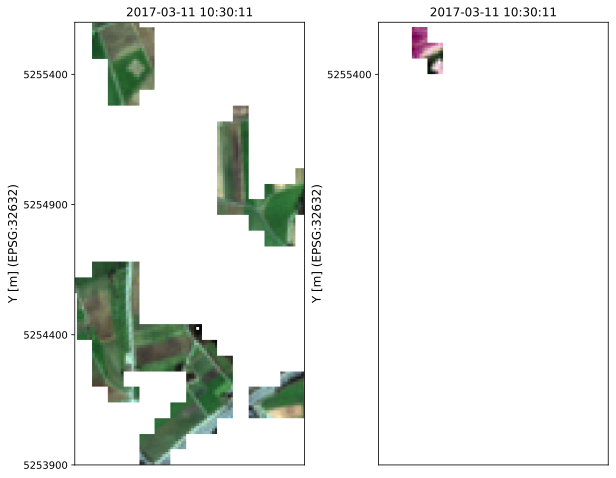

In [33]:
# Plot 10m resolution with no geom buffer

res_baresoil_nobuffer = extract_s2_data(
  aoi=aoi,
  time_start=datetime(2017,3,1),
  time_end=datetime(2017,3,31)
)

scoll = res_baresoil_nobuffer.data
f, axes = plt.subplots(1,2,figsize=(10,8))
for scene_id, scene in scoll:
    scene.plot_multiple_bands(
        band_selection=['red', 'green' ,'blue'],
        ax=axes[0]
    )
    axes[0].set_title(scene_id)
    axes[0].set_xlabel('')
    axes[0].get_xaxis().set_ticks([])
    axes[0].set_ylim((5253900, 5255600))
    axes[0].set_xlim((475793, 476675))
    break


# Plot 10m resolution with -60m buffer

res_baresoil_buffer = extract_s2_data(
  aoi=aoi_with_buffer,
  time_start=datetime(2017,3,1),
  time_end=datetime(2017,3,31)
)

scoll = res_baresoil_buffer.data
for scene_id, scene in scoll:
    scene.plot_multiple_bands(
        band_selection=['red', 'green' ,'blue'],
        ax=axes[1]
    )
    axes[1].set_title(scene_id)
    axes[1].set_xlabel('')
    axes[1].get_xaxis().set_ticks([])
    axes[1].set_ylim((5253900, 5255600))
    axes[1].set_xlim((475793, 476675))
    break

plt.show()

In [77]:
res_baresoil = extract_s2_data(
  aoi=aoi_with_buffer,
  time_start=datetime(2017,3,1),
  time_end=datetime(2017,6,30)
)

getting scenes


2024-02-05 15:56:36,374 eodal        INFO     Starting extraction of sentinel2 scenes


None


2024-02-05 15:57:23,564 eodal        INFO     Finished extraction of sentinel2 scenes


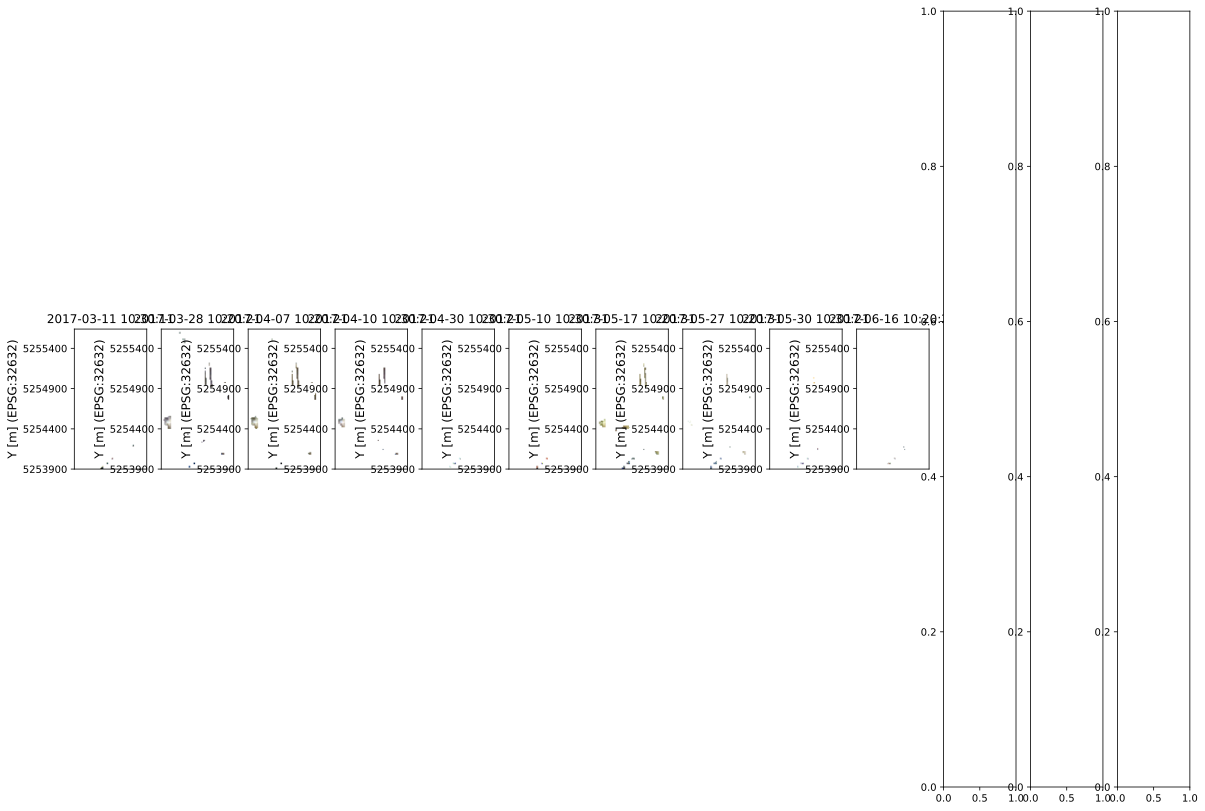

In [78]:
# Plot
scoll = res_baresoil.data
f, axes = plt.subplots(ncols=len(scoll), nrows=1, figsize=(20,14))
idx = 0
for scene_id, scene in scoll:
    scene.plot_multiple_bands(
        band_selection=['red', 'green' ,'blue'],
        ax=axes[idx]
    )
    axes[idx].set_title(scene_id)
    axes[idx].set_xlabel('')
    axes[idx].get_xaxis().set_ticks([])
    idx += 1
    if idx==10:
        break

In [79]:
# Save mapper for reloading later

# Save data for future use
fpath = base_dir.joinpath(f'results/eodal_baresoil_s2_data_test.pkl')
with open(fpath, 'wb+') as dst:
    dst.write(res_baresoil.data.to_pickle())
    
# Also save metadata because we need info on the sensor
metadata_path = fpath.with_name(fpath.name.replace('data', 'metadata'))
with open(metadata_path, 'wb+') as dst:
    pickle.dump(res_baresoil.metadata, dst)

In [80]:
fpath = base_dir.joinpath(f'results/eodal_baresoil_s2_data_test.pkl')
scoll = SceneCollection.from_pickle(stream=base_dir.joinpath(fpath))

metadata_path = fpath.with_name(fpath.name.replace('data', 'metadata'))
metadata = pd.read_pickle(metadata_path)

## Sample bare soil spectra from scenes
- open the save files that are already filtered for bare soil
- sample pixel spectra

In [25]:
fpath = base_dir.joinpath(f'results/eodal_baresoil_s2_data_test.pkl')
scoll = SceneCollection.from_pickle(stream=base_dir.joinpath(fpath))

metadata_path = fpath.with_name(fpath.name.replace('data', 'metadata'))
metadata = pd.read_pickle(metadata_path)

In [26]:
def compute_scoll_percentiles(scoll):
  ''' 
  Find the 1st and 99th percentile for each band in the scene collection

  :params scolle: EOdal scene collection object
  '''
  lower_threshold = {}
  upper_threshold = {}
  bands = ['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A','B11', 'B12']

  for scene_id, scene in scoll:
    df_scene = scene.to_dataframe()
    # Compute 1st and 99th percentiles for each band across whole scoll
    for band in bands:
        if band not in lower_threshold:
            lower_threshold.update({band: float('inf')})  # Initialize to positive infinity
        if band not in upper_threshold:
            upper_threshold.update({band: float('-inf')})  # Initialize to negative infinity

        band_values = df_scene[band].dropna().values  # Drop NaN values for the band
        if len(band_values) > 0:
            band_lower = np.percentile(band_values, 1)
            band_upper = np.percentile(band_values, 99)

            # Update lower_threshold and upper_threshold for each band
            lower_threshold[band] = min(lower_threshold[band], band_lower)
            upper_threshold[band] = max(upper_threshold[band], band_upper)

  return lower_threshold, upper_threshold


# Function to filter dataframe based on lower and upper thresholds for each band
def filter_dataframe(df, lower_threshold, upper_threshold, bands):
    '''
    Remove pixels where a band is below/above the 1st/99th percentile (across the whole collection of scenes)

    :param df: dataframe to filter
    :param lower_threshold: dictionary with lower thresh values for each band
    :param upper_threshol: dictionary with upper thresh values for each band
    :param bands: columns in df that correspond to bands to filter
    '''
    for band in bands:
        if band == 'B01':
            # don't use B01 for filtering, just for future interpolation
            continue
        else:
            lower_thr = lower_threshold[band]
            upper_thr = upper_threshold[band]
            # Set values outside the threshold to np.nan
            df[band] = np.where((df[band] < lower_thr) | (df[band] > upper_thr), np.nan, df[band])
    
    df = df.dropna()
    return df

In [99]:
def find_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []

    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
        kmeans.fit(data)
        if i > 2:
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Find the optimal number of clusters
    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # Adding 2 due to starting from 2 clusters

    """
    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(range(3, max_clusters + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Scores for Optimal Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()
    """

    return optimal_clusters
    
    
def sample_bare_pixels(scoll, metadata, lower_threshold, upper_threshold, samples_per_cluster):
  '''
  Sample bare pixels from scenes based on k-means clustering.
  Use the top 5 scenes where there were the most nu,ber of bare pixels (clearest days with bare pixels)
  '''

  bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A','B11', 'B12']
  pixs_df = pd.DataFrame()

  for i, row in metadata.sort_values(by='n_bare', ascending=False).head(5).iterrows():
    date = row['sensing_date']
    sensor = row['spacecraft_name']

    # Get scene for that date
    scoll_idx = [i for i, _ in scoll if i.date()==date][0]
    scene = scoll.__getitem__(scoll_idx) # get scene collection

    # Get pixels in scene
    pixs = scene.to_dataframe()

    # Remove top and botthom 1% for each band 
    pixs = filter_dataframe(pixs, lower_threshold, upper_threshold, bands)

    if len(pixs):
      # Add some useful metadata: sensing date, sensor
      pixs['sensing_date'] = [date]*len(pixs)
      pixs['sensor'] = [sensor]*len(pixs)
      pixs_df = pd.concat([pixs_df, pixs])
  
  # Apply k-means clustering on the pixel dataset
  optimal_clusters = find_optimal_clusters(pixs_df[bands], max_clusters=10)
  num_clusters = min(optimal_clusters, len(pixs_df))
  print(f'Sampling from {num_clusters} clusters')
  if len(pixs_df)<=num_clusters:
    print('Warning: all pixels will be sampled as ther are not enough samples for k-means clustering')
  kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
  pixs_df['cluster'] = kmeans.fit_predict(pixs_df[bands])

  # Sample one pixel from each cluster
  samples = []
  for cluster_id in range(num_clusters):
    cluster_pixs = pixs_df[pixs_df['cluster'] == cluster_id]
    if not cluster_pixs.empty:
      # Sample one pixel from this cluster
      sampled_rows = cluster_pixs.sample(samples_per_cluster)
      samples.extend(sampled_rows.to_dict(orient='records'))

  # Convert GeoDataFrames to DataFrames before creating the final DataFrame
  df_sampled = pd.DataFrame(samples)

  return df_sampled

In [100]:
# Compute band percentile thresholds in scene collection
lower_threshold, upper_threshold = compute_scoll_percentiles(scoll)

In [101]:
df_sampled = sample_bare_pixels(scoll, metadata, lower_threshold, upper_threshold, 5)

2


## Resample to 1nm resolution

In [14]:
s2a = [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 1613.7, 2202.4]
s2b = [442.2, 492.1, 559.0, 664.9, 703.8, 739.1, 779.7, 832.9, 864.0, 1610.4, 2185.7]
new_wavelengths = np.arange(400, 2501, 1)

In [19]:
def upsample_spectra(df, wavelengths, new_wavelengths):
    '''
    Upsample spectra from a sensor

    :param df: dataframe containing pixel spectra all oroginaitng from one sensor
    :param wavelengths: sensor wavelengths
    :param new_wavelengths: wavelengths to upsample to
    '''
    # Interpolate along the rows (pixels) for each wavelength
    interpolated_data = {}
    for index, row in df.iterrows():
        row['2500'] = row.min()
        f = interp1d(wavelengths + [2500], row, kind='cubic', fill_value="extrapolate")
        #f = interp1d(wavelengths, row, kind='cubic', fill_value=(row.min(), row.max()), bounds_error=False)

        interpolated_data[index] = f(new_wavelengths)

    # Create a new DataFrame with the interpolated data
    interpolated_df = pd.DataFrame(interpolated_data, index=new_wavelengths)

    # Transpose the DataFrame to have pixels as columns
    interpolated_df = interpolated_df.T

    # Print the result
    return interpolated_df

In [20]:
def resample_df(df_sampled, s2a, s2b):
  '''
  Resample all sampled pixels from Sentinel-2A and Sentinel-2B
  
  :param df_sampled:
  :param s2a: wavelengths for Sentinel-2A
  :param s2b: wavelengths for Sentinel-2B
  :param new_wavelengths: wavelegnths to upsample to
  '''

  s2a_df = df_sampled[df_sampled['sensor'] == 'Sentinel-2A']
  s2b_df = df_sampled[df_sampled['sensor'] == 'Sentinel-2B']
  df_list = [s2a_df, s2b_df]

  spectra = pd.DataFrame()

  for df in df_list:
    if len(df):
      s2_vals = df[['B01','B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']]

      # Resample to 1nm
      if np.unique(df.sensor) == 'Sentinel-2A':
        df_new = upsample_spectra(s2_vals, s2a, new_wavelengths)
      if np.unique(df.sensor) == 'Sentinel-2B':
        df_new = upsample_spectra(s2_vals, s2b, new_wavelengths)
      
      # Append
      spectra = pd.concat([spectra, df_new])
  
  return spectra

In [21]:
spectra = resample_df(df_sampled, s2a, s2b)

In [70]:
# Export spectra
spectra_path = base_dir.joinpath(f'results/sampled_spectra_test.pkl')
with open(spectra_path, 'wb+') as dst:
    pickle.dump(spectra, dst)


In [189]:
"""
spectra = pd.DataFrame()

for scene_id, scene in scoll:
  # Get some pixels from that scene (could aslo additionally filter with SCL)
  pixs = scene.to_dataframe().sample(5)
  pixs_s2 = pixs[['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']]
  # Get sensor
  sensor = metadata[metadata.sensing_date == scene_id.date()].spacecraft_name.values
  print(sensor)
  # Resample to 1nm
  if sensor == 'Sentinel-2A':
    df = upsample_spectra(pixs_s2, s2a, new_wavelengths)
  if sensor == 'Sentinel-2B':
    df = upsample_spectra(pixs_s2, s2b, new_wavelengths)
  # Append
  spectra = pd.concat([spectra, df])
  break

# TO DO: export spectra as txt file or other
"""

['Sentinel-2A']


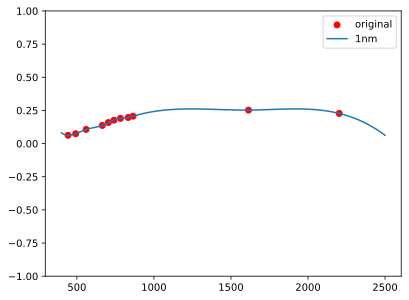

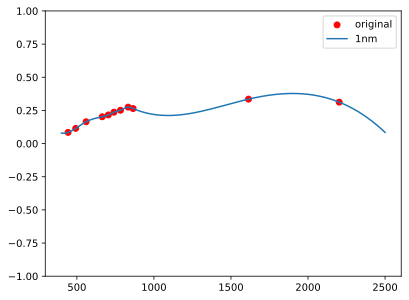

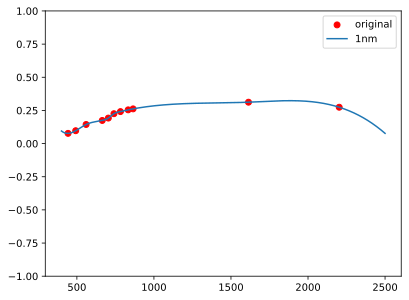

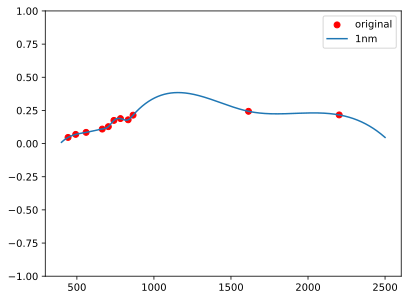

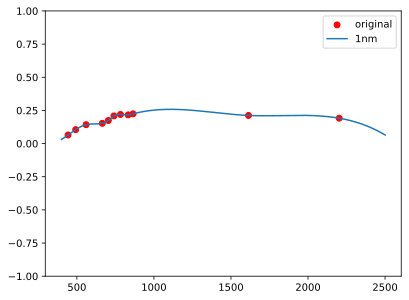

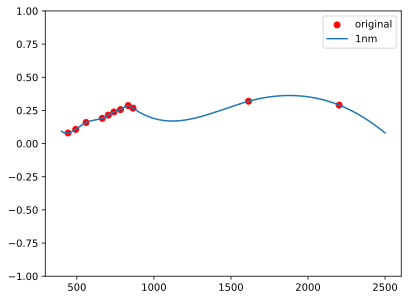

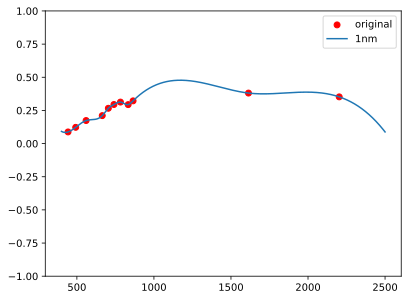

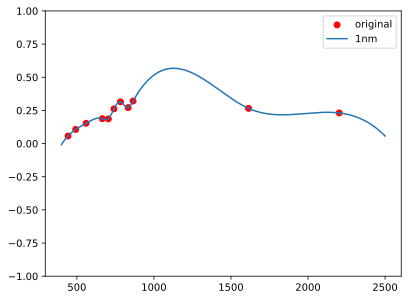

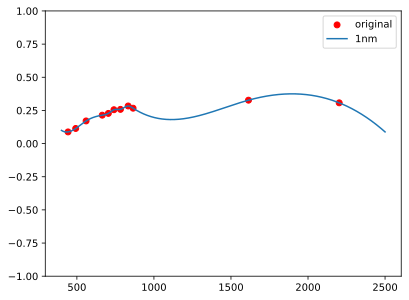

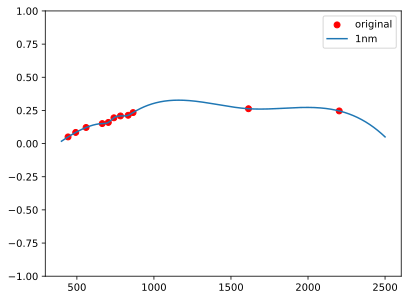

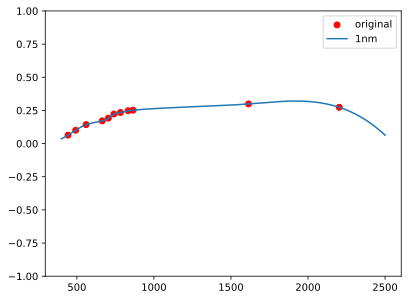

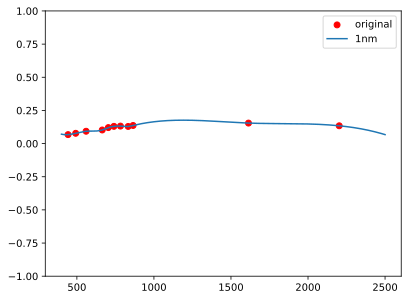

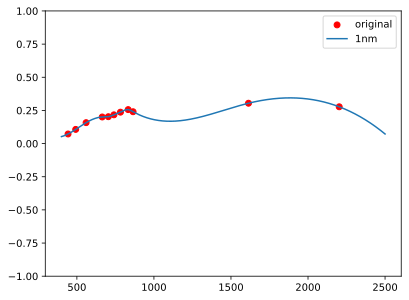

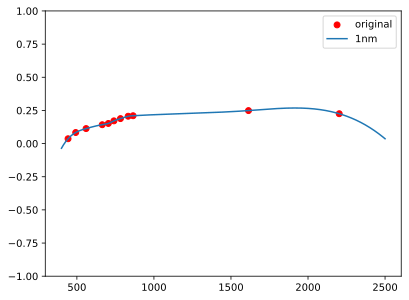

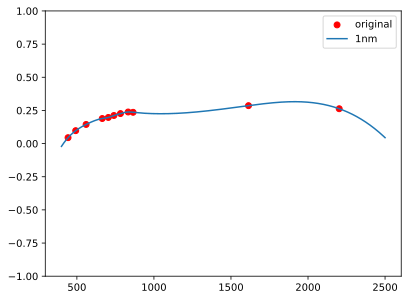

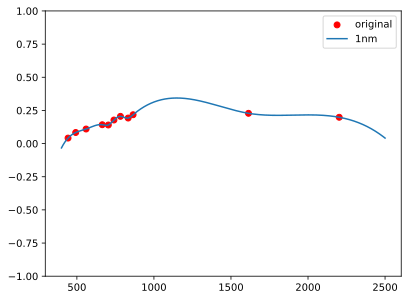

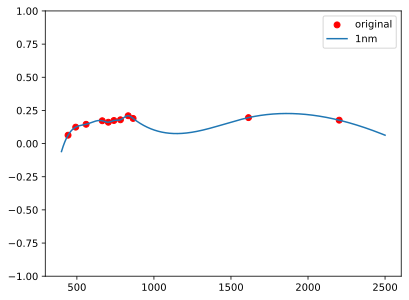

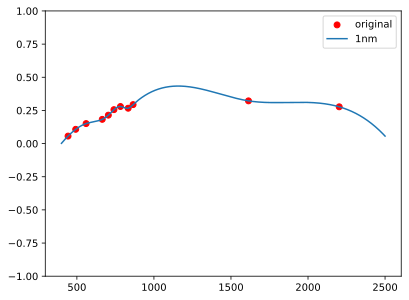

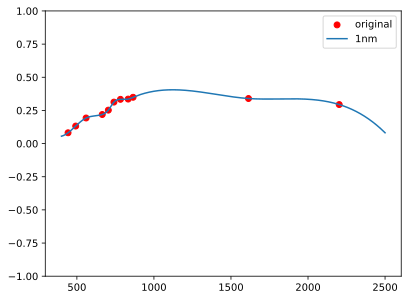

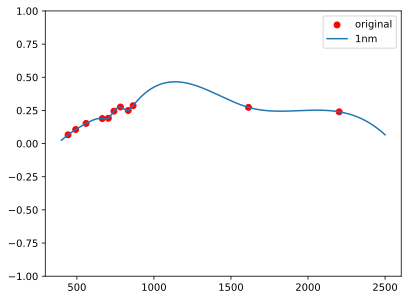

In [18]:
# Compare before and after
df_sampled_s2 = df_sampled[['B01','B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']]

for i, r in df_sampled_s2.iterrows():
  plt.scatter(s2a, r, label='original', color='r')
  plt.plot(new_wavelengths, spectra.loc[i], label=f'1nm')
  plt.legend()
  plt.ylim((-1,1))
  plt.show()

## Analyse sampled pixels with k-means

In [230]:
pixs_path = base_dir.joinpath(f'results/sampled_pixels_Witzwil.pkl')
pixs = pd.read_pickle(pixs_path)
pixs_gdf = gpd.GeoDataFrame(pixs).set_crs('EPSG:32632')

spectra_path = base_dir.joinpath(f'results/sampled_spectra_Witzwil.pkl')
spectra = pd.read_pickle(spectra_path)

In [231]:
pixs_gdf.sensing_date

0     2023-12-30
1     2023-12-30
2     2023-12-30
3     2023-12-30
4     2023-12-30
5     2023-12-30
6     2023-12-30
7     2023-12-30
8     2023-12-30
9     2023-12-30
10    2023-12-30
11    2023-12-30
12    2023-12-30
13    2023-12-30
14    2023-12-30
Name: sensing_date, dtype: object

In [232]:
shp_path = base_dir.joinpath(f'data/Witzwil.shp')
aoi = gpd.read_file(shp_path)

In [233]:
aoi.crs

<Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

<Axes: >

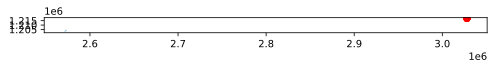

In [234]:
fig, ax = plt.subplots(figsize=(8, 6))
aoi.plot(ax=ax)
pixs_gdf.to_crs(aoi.crs).plot(ax=ax, color='red')

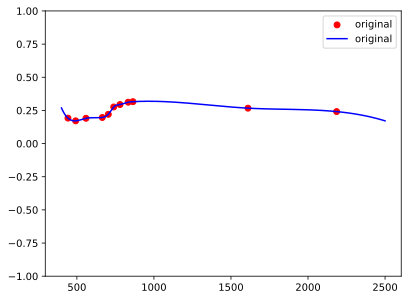

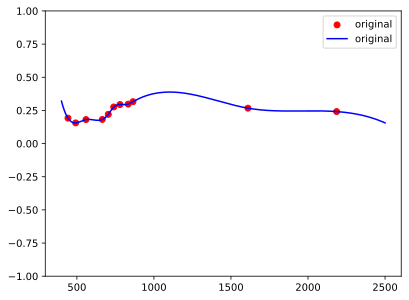

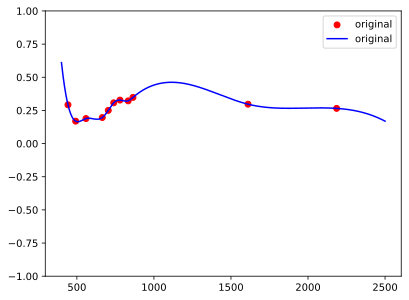

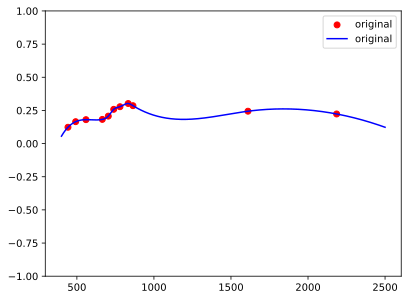

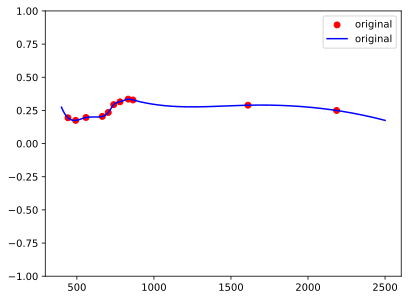

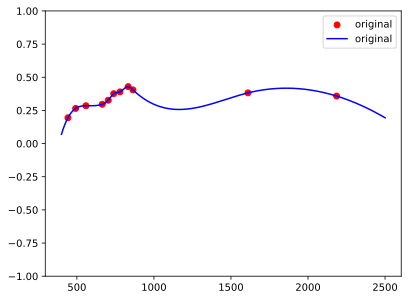

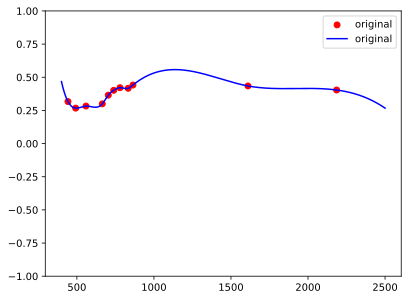

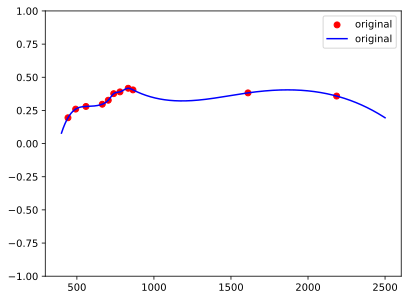

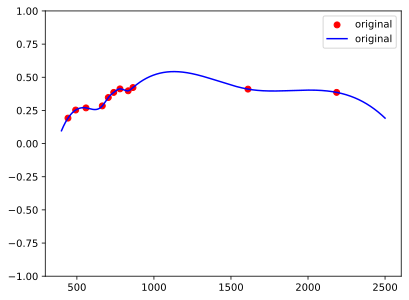

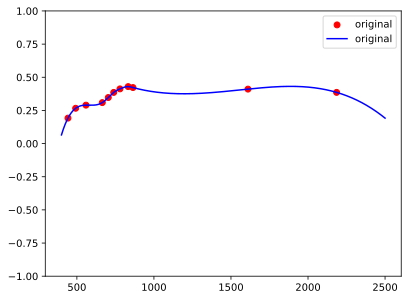

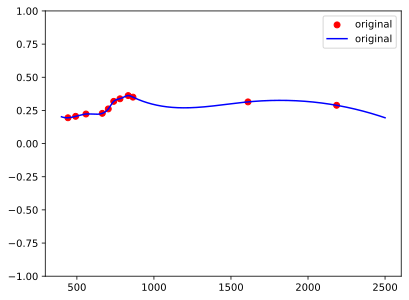

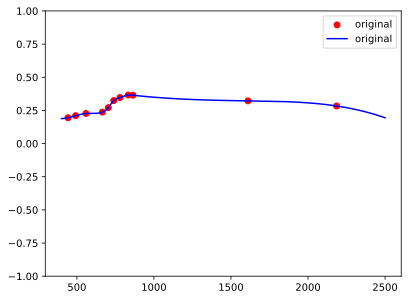

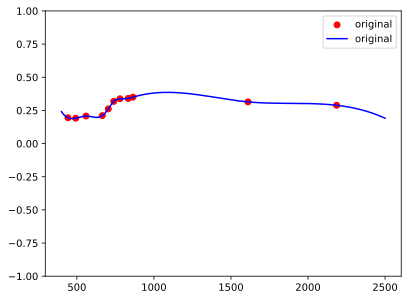

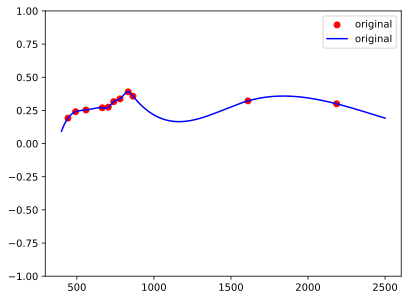

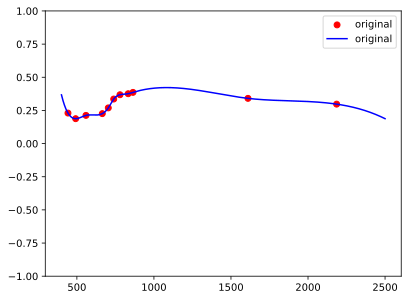

In [198]:
# Plot the sampled pixels

bands = ['B01','B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12']

for i, r in pixs_gdf.iterrows():
  if r['sensor'] == 'Sentinel-2A':
    plt.scatter(s2a, r[bands], label='original', color='r')
    plt.plot(new_wavelengths, spectra.loc[i], label='original', color='b')
  elif r['sensor'] == 'Sentinel-2B':
    plt.scatter(s2b, r[bands], label='original', color='r')
    plt.plot(new_wavelengths, spectra.loc[i], label='original', color='b')
  plt.legend()
  plt.ylim((-1,1))
  plt.show()

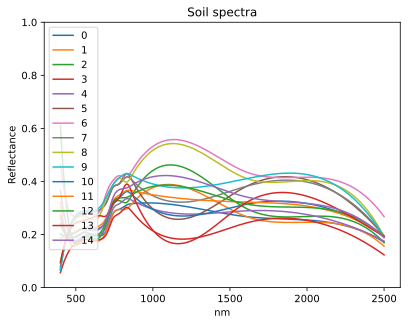

In [211]:
# See all the soil spectra that were sampled
spectra.T.plot()
plt.xlabel('nm')
plt.ylabel('Reflectance')
plt.title('Soil spectra')
plt.ylim((0,1))
plt.show()


## Analyze sampled + interpolated spectra

In [246]:
spectra_path = base_dir.joinpath(f'results/sampled_spectra_Strickhof.pkl')
spectra = pd.read_pickle(spectra_path)
print(len(spectra))

10


In [243]:
spectra_path = base_dir.joinpath(f'results/sampled_spectra_all.pkl')
spectra = pd.read_pickle(spectra_path)
print(len(spectra))
spectra = pd.read_pickle(spectra_path).sample(10)

35


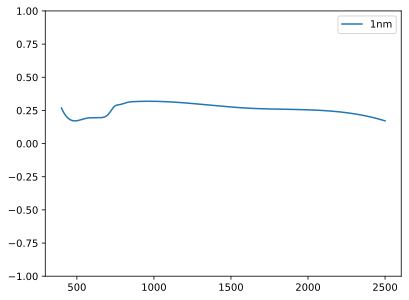

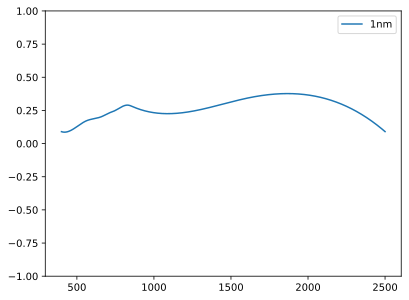

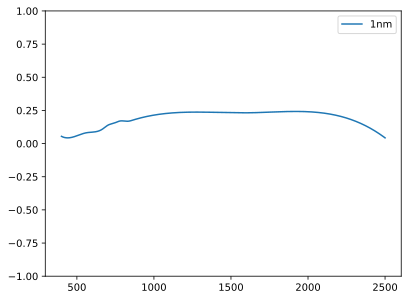

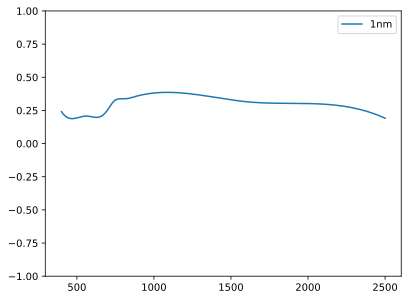

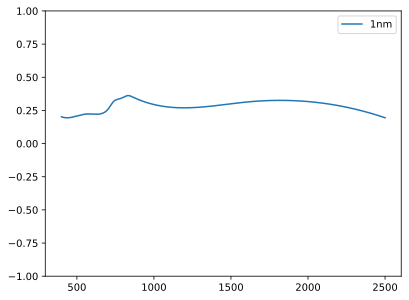

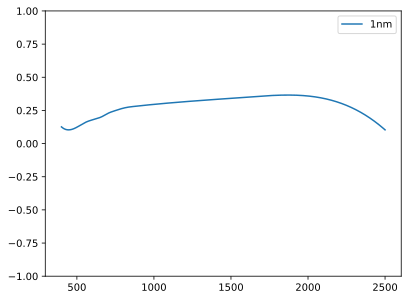

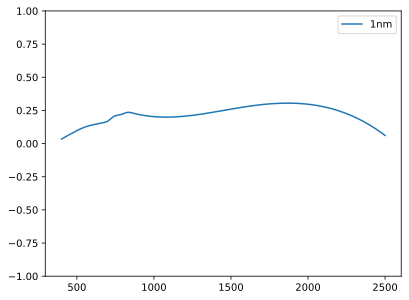

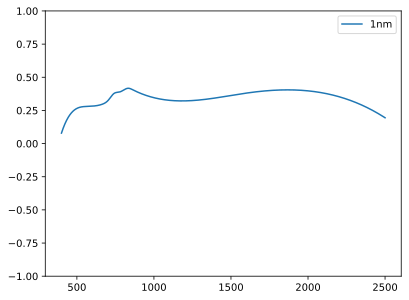

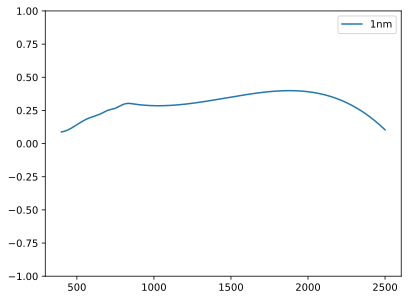

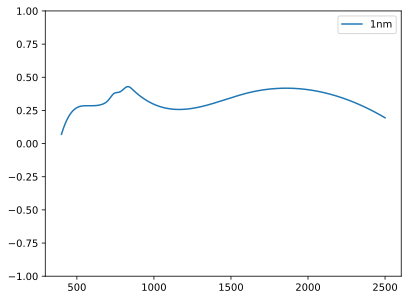

In [240]:
for i, r in spectra.iterrows():
  plt.plot(new_wavelengths, r, label=f'1nm')
  plt.legend()
  plt.ylim((-1,1))
  plt.show()

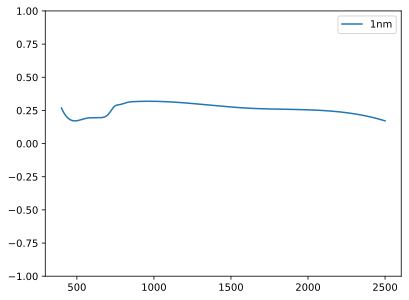

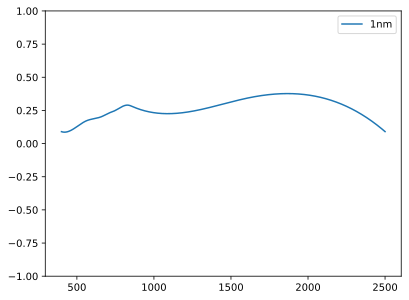

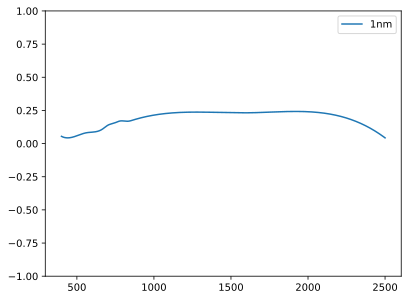

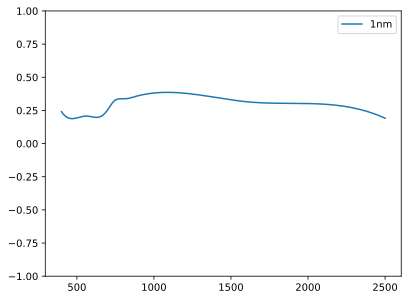

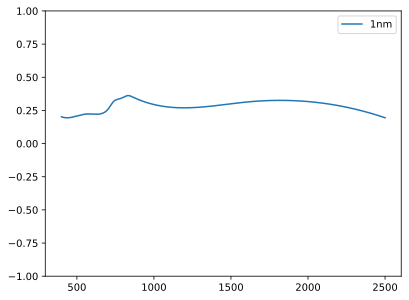

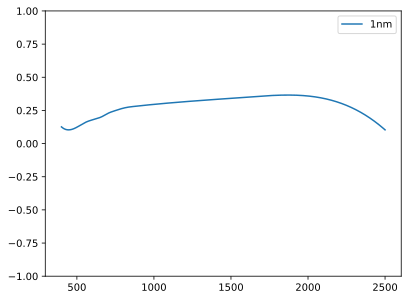

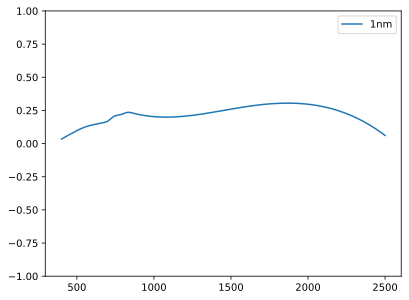

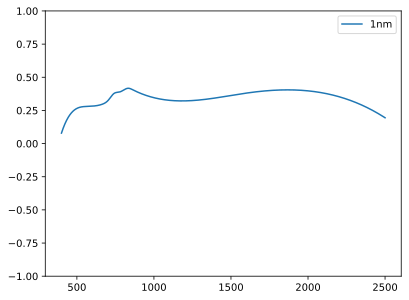

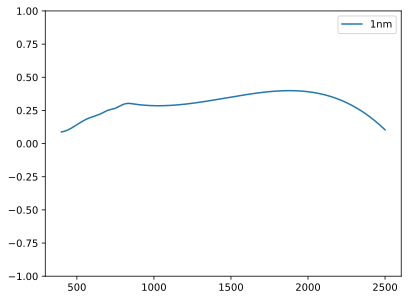

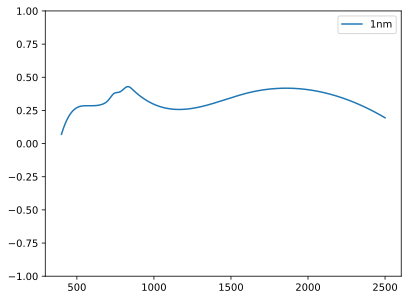

In [241]:
for i, r in spectra.iterrows():
  plt.plot(new_wavelengths, r, label=f'1nm')
  plt.legend()
  plt.ylim((-1,1))
  plt.show()

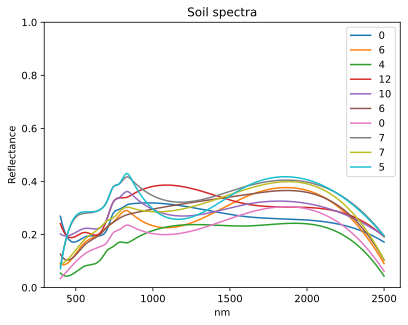

In [242]:
# See all the soil spectra that were sampled
spectra.T.plot()
plt.xlabel('nm')
plt.ylabel('Reflectance')
plt.title('Soil spectra')
plt.ylim((0,1))
plt.show()
